# Inspect Parquet

In [6]:
import pyarrow.parquet as pq
import pandas as pd

def inspect_parquet(parquet_path, num_rows=5):
    """
    Reads a local Parquet file, prints basic information about the data,
    and shows the first few rows (default 5).
    """
    print(f"Reading Parquet file: {parquet_path}")
    table = pq.read_table(parquet_path)
    print(f"Schema:\n{table.schema}\n")

    df = table.to_pandas()
    print(f"Total rows: {len(df)}")
    print(f"Columns: {df.columns.tolist()}\n")

    # Show a few rows
    print(f"First {num_rows} rows:\n")
    print(df.head(num_rows))
    
    output_csv_path = parquet_path.replace('.parquet', '_head.csv')
    df.head(num_rows).to_csv(output_csv_path, index=False)
    print(f"Saved first {num_rows} rows to CSV: {output_csv_path}")


# Example usage: adapt the paths to your local environment
parquet_file_1 = "/home/s2652867/llm-self-play-liquidhaskell/data/jtatman-python-code-dataset-500k/train-00000-of-00002.parquet"
parquet_file_2 = "/home/s2652867/llm-self-play-liquidhaskell/data/jtatman-python-code-dataset-500k/train-00001-of-00002.parquet"

# Inspect the first file
inspect_parquet(parquet_file_1, num_rows=5)
print("\n" + "="*50 + "\n")
# Inspect the second file
inspect_parquet(parquet_file_2, num_rows=5)



Reading Parquet file: /home/s2652867/llm-self-play-liquidhaskell/data/jtatman-python-code-dataset-500k/train-00000-of-00002.parquet
Schema:
output: string
instruction: string
system: string
-- schema metadata --
huggingface: '{"info": {"features": {"output": {"dtype": "string", "_type' + 117

Total rows: 279758
Columns: ['output', 'instruction', 'system']

First 5 rows:

                                              output  \
0  Here is an example of a nested loop in Python ...   
1  The given problem can be solved by iterating t...   
2  Here's an example of code that attempts to sol...   
3  Here is an implementation of the function in P...   
4  Here's a possible implementation of the method...   

                                         instruction  \
0  Create a nested loop to print every combinatio...   
1  Write a function to find the number of distinc...   
2  Write code that removes spaces and punctuation...   
3  Write a function that checks if a given number...   
4  Write 

# Train/Val Loss Graph

seaborn-whitegrid style not found. Falling back to default style.


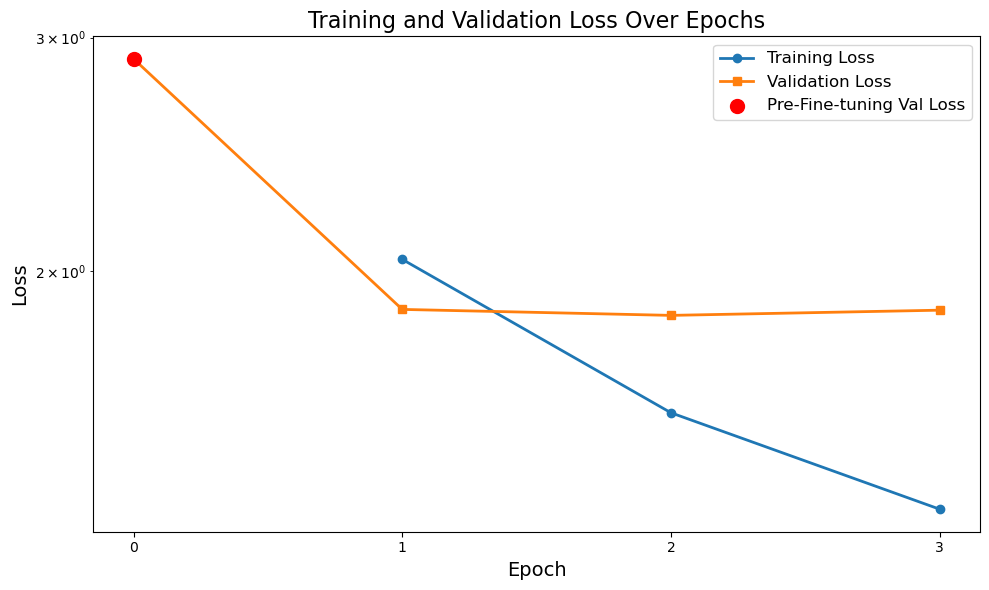

In [7]:
import re
import matplotlib.pyplot as plt

# Path to your log file
log_path = "/home/s2652867/llm-self-play-liquidhaskell/log/output/output_2025-03-23_21-08-18.log"

def generate_loss_graph(log_path):
    # Dictionaries to store loss values per epoch
    train_loss_dict = {}
    val_loss_dict = {}

    # Variable to store pre-fine-tuning validation loss (epoch 0)
    pre_val_loss = None

    # Regular expressions to match the loss lines
    pre_val_loss_regex = re.compile(r"Pre-Fine-tuning - Validation Loss: ([\d\.]+)")
    train_loss_regex   = re.compile(r"Epoch (\d+) - Average Training Loss: ([\d\.]+)")
    val_loss_regex     = re.compile(r"Epoch (\d+) - Validation Loss: ([\d\.]+)")

    # Read and parse the log file
    with open(log_path, "r") as f:
        for line in f:
            # Check for pre-training validation loss
            pre_match = pre_val_loss_regex.search(line)
            if pre_match and pre_val_loss is None:
                pre_val_loss = float(pre_match.group(1))
            
            # Check for training loss
            train_match = train_loss_regex.search(line)
            if train_match:
                epoch = int(train_match.group(1))
                loss = float(train_match.group(2))
                train_loss_dict[epoch] = loss

            # Check for epoch validation loss
            val_match = val_loss_regex.search(line)
            if val_match:
                epoch = int(val_match.group(1))
                loss = float(val_match.group(2))
                val_loss_dict[epoch] = loss

    # Prepare epoch lists. We assign epoch 0 for pre-fine-tuning validation loss.
    if pre_val_loss is not None:
        val_epochs = [0] + sorted(val_loss_dict.keys())
        # For validation, insert the pre-training value at epoch 0,
        # then for each epoch, the logged validation loss.
        val_losses = [pre_val_loss] + [val_loss_dict[epoch] for epoch in sorted(val_loss_dict.keys())]
    else:
        val_epochs = sorted(val_loss_dict.keys())
        val_losses = [val_loss_dict[epoch] for epoch in val_epochs]

    # Training loss is available from epoch 1 onward.
    train_epochs = sorted(train_loss_dict.keys())
    train_losses = [train_loss_dict[epoch] for epoch in train_epochs]

    # Use an academic style; fall back if 'seaborn-whitegrid' is unavailable.
    try:
        plt.style.use("seaborn-whitegrid")
    except Exception as e:
        print("seaborn-whitegrid style not found. Falling back to default style.")
        plt.style.use("default")

    plt.figure(figsize=(10, 6))

    # Plot training loss (starting from epoch 1)
    plt.plot(train_epochs, train_losses, marker="o", linewidth=2, label="Training Loss")

    # Plot validation loss (including pre-training as epoch 0)
    plt.plot(val_epochs, val_losses, marker="s", linewidth=2, label="Validation Loss")

    # Mark the pre-fine-tuning validation loss distinctly
    if pre_val_loss is not None:
        plt.scatter(0, pre_val_loss, color="red", s=100, zorder=5, label="Pre-Fine-tuning Val Loss")

    # Add labels, title, and legend with academic styling
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.yscale("log")   # Logarithmic scale for better visualization
    plt.title("Training and Validation Loss Over Epochs", fontsize=16)
    plt.xticks(range(0, max(val_epochs)+1))
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

generate_loss_graph(log_path)

# End